In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
import matplotlib.pyplot as plt

In [207]:

data = pd.read_csv('lyrics_entropy.csv')#, parse_dates=['year'], index_col='year')
#data.sort_index(inplace= True)
avg_ent_year = pd.read_csv('avg_ent_year.csv')

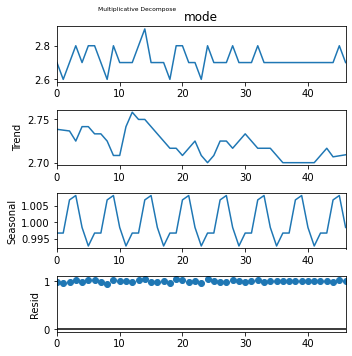

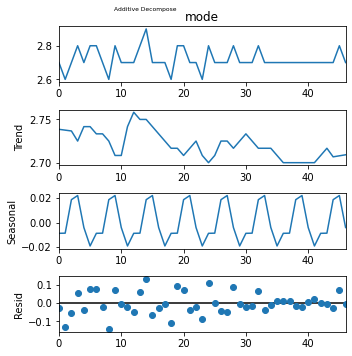

In [209]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(avg_ent_year['mode'], model='multiplicative', extrapolate_trend='freq', period = 6)

# Additive Decomposition
result_add = seasonal_decompose(avg_ent_year['mode'], model='additive', extrapolate_trend='freq', period = 6)

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=6, horizontalalignment = 'right')
result_add.plot().suptitle('Additive Decompose', fontsize=6, horizontalalignment = 'right')
plt.show()

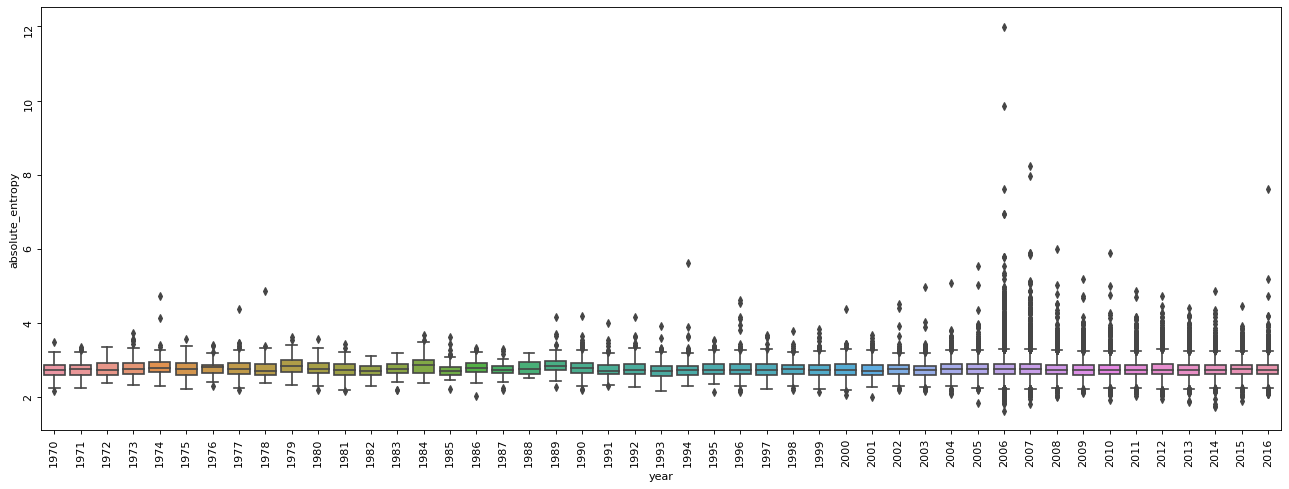

In [13]:
import seaborn as sns
# Draw Plot

plt.figure( figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='absolute_entropy', data=data)
plt.xticks(rotation=90)
plt.yticks(rotation=90)

plt.show()

In [ ]:
#-------LET'S SPLIT THE SEXES--------------------------

In [252]:
data['rounded_ent'] = round(data['absolute_entropy'],1)

In [253]:
fem = data[data['gender'] == 'F']
male = data[data['gender'] == 'M']

In [254]:
ns = []
avgs = []
years = []
modes = []

for i in fem.year.unique():
    year = i
    sumOfNumbers = sum(fem[fem['year'] == i]['absolute_entropy'])
    n = len(fem[fem['year'] == i])
    avg = sumOfNumbers / n
    mode = fem[fem['year'] == i]['rounded_ent'].mode()[0]
  
    
    ns.append(n)
    avgs.append(avg)
    years.append(year)
    modes.append(mode)

    
result = {
'year':pd.Series(years),
'n_songs':pd.Series(ns),
'average_ent':pd.Series(avgs),
'mode':pd.Series(modes)
}
    
fem_sum = pd.DataFrame(result)


In [255]:
ns = []
avgs = []
years = []
modes = []

for i in male.year.unique():
    year = i
    sumOfNumbers = sum(male[male['year'] == i]['absolute_entropy'])
    n = len(male[male['year'] == i])
    avg = sumOfNumbers / n
    mode = male[male['year'] == i]['rounded_ent'].mode()[0]
  
    
    ns.append(n)
    avgs.append(avg)
    years.append(year)
    modes.append(mode)

    
result = {
'year':pd.Series(years),
'n_songs':pd.Series(ns),
'average_ent':pd.Series(avgs),
'mode':pd.Series(modes)
}
    
male_sum = pd.DataFrame(result)


In [256]:
#let's calculate the change between modes over time
fem_sum['change_mode'] = fem_sum['mode'].diff()
#let's calculate the change between averages over time
fem_sum['change_average'] = fem_sum['average_ent'].diff()


#let's calculate the change between modes over time
male_sum['change_mode'] = male_sum['mode'].diff()
#let's calculate the change between averages over time
male_sum['change_average'] = male_sum['average_ent'].diff()

In [212]:
# calculate forecastability
import numpy as np

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(fem_sum['mode'], m=2, r=0.2*np.std(avg_ent_year['mode'])))   

print(ApEn(male_sum['mode'], m=2, r=0.2*np.std(avg_ent_year['mode'])))   


0.7899310600321181
0.7022576906594786


In [214]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(fem_sum['mode'], m=2, r=0.2*np.std(avg_ent_year['mode'])))      
print(SampEn(male_sum['mode'], m=2, r=0.2*np.std(avg_ent_year['mode'])))  

1.0986122886681098
0.9189538492936388


In [42]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 1.0 MB/s eta 0:00:01


In [43]:
#SARIMA
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm

In [86]:
#CHECKING FOR STATIONARITY
#ADF: if the p-value is less than the critical value, the series is stationary
#OSCB: if the value is less than 0.64, the series is stationary

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(avg_ent_year['mode']))

Results of Dickey-Fuller Test:
Test Statistic                -6.932772e+00
p-value                        1.073504e-09
#Lags Used                     0.000000e+00
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
dtype: float64
None


In [ ]:
#Results of Dickey-Fuller Test:
#Test Statistic                -6.932772e+00
#p-value                        1.073504e-09 - greater than 0.05 --> non-statoinary data ---> do differencing and check again
#Lags Used                     0.000000e+00
#Number of Observations Used    4.600000e+01
#Critical Value (1%)           -3.581258e+00
#Critical Value (5%)           -2.926785e+00
#Critical Value (10%)          -2.601541e+00
#dtype: float64
#None

Results of Dickey-Fuller Test:
Test Statistic                 -3.904157
p-value                         0.002004
#Lags Used                      9.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64
None


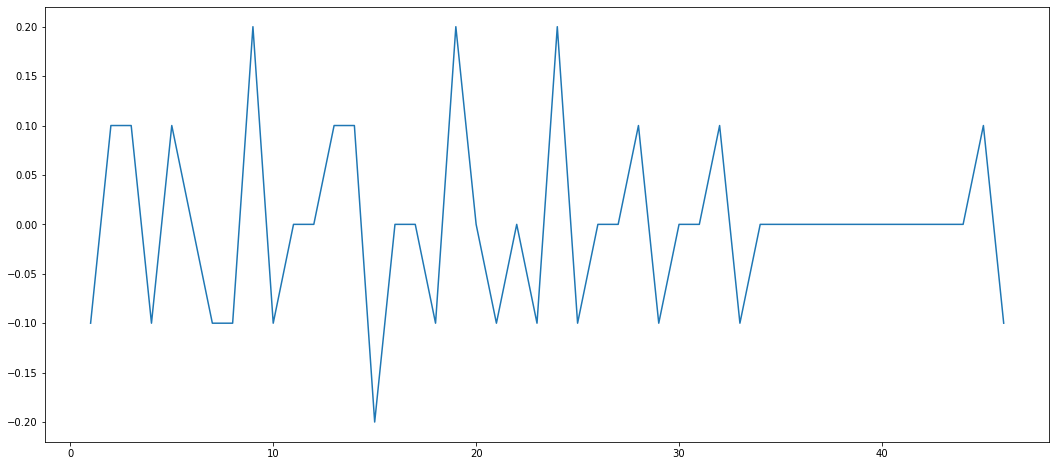

In [106]:
diff1 = avg_ent_year['mode'] - avg_ent_year['mode'].shift(1)   #-----> first order differencing, to remove trend from data
diff1 = diff1.dropna()
diff1.plot()

print(adf_test(diff1))

In [ ]:
#Results of Dickey-Fuller Test:
#Test Statistic                 -3.904157
#p-value                         0.002004  --> it is lower than 0.05, which means our data is stationary, yay!
#Lags Used                      9.000000
#Number of Observations Used    36.000000
#Critical Value (1%)            -3.626652
#Critical Value (5%)            -2.945951
#Critical Value (10%)           -2.611671
#dtype: float64
#None

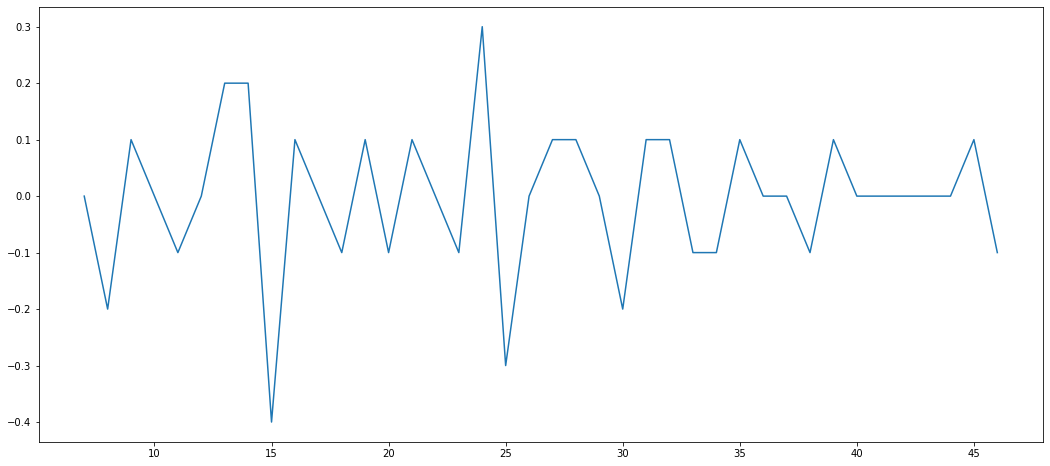

In [109]:
#but since we think there is a seasonal component every 6 years, let's difference that too
diff6 = diff1 - diff1.shift(6)
diff6 = diff6.dropna()
diff6.plot()

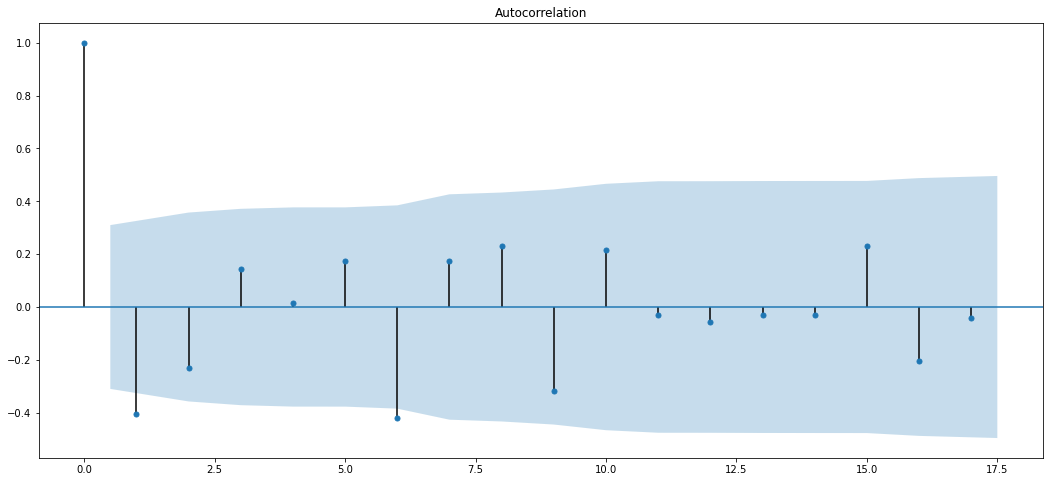

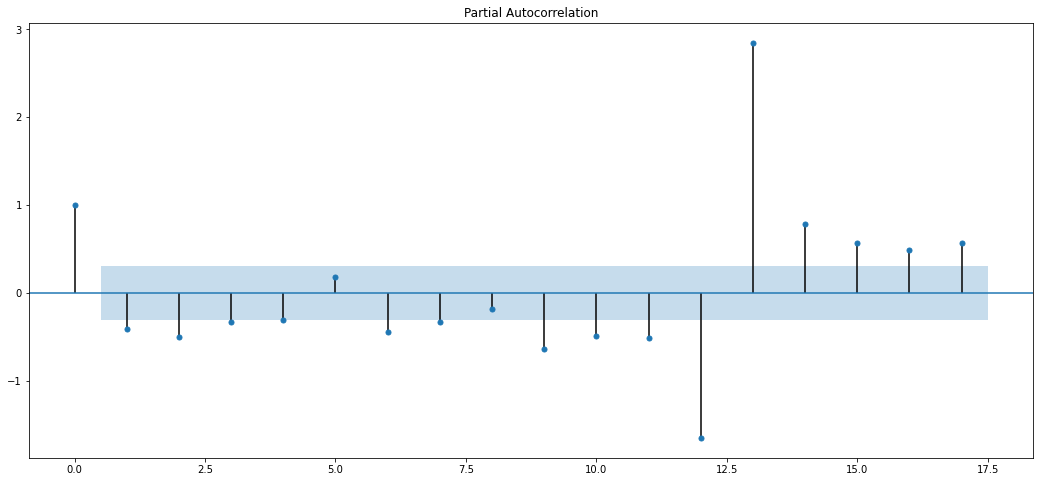

In [111]:
#By now, we have been able to identify 3 out of 7 components for our SARIMA equation. 
#Those are trend differencing order(d), seasonal differencing order(D) and lag = 6.
#Let us now try and figure out the other 4 components, i.e – p and seasonal P, q and seasonal Q. 
#In order to figure these out, we would need to plot the ACF and PACF plots.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff6)
matplotlib.pyplot.show()
plot_pacf(diff6)
matplotlib.pyplot.show()

In [ ]:
#On acf, initial spike at lag = 1, seasonal spike at lag = 6 AR order: 1, SAR order: 6
# on the pacf plot initial = 12, seasonal: 12, MA = 1, sMA = 2

In [113]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 6)
SARIMAX: (0, 1, 1) x (0, 1, 2, 6)
SARIMAX: (0, 1, 2) x (1, 1, 0, 6)
SARIMAX: (0, 1, 2) x (1, 1, 1, 6)


In [155]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(avg_ent_year['mode'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}6 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 6)6 - AIC:-44.673182357954644
ARIMA(0, 1, 0)x(0, 1, 1, 6)6 - AIC:-50.88527858925223
ARIMA(0, 1, 0)x(0, 1, 2, 6)6 - AIC:1351.3287343375657
ARIMA(0, 1, 0)x(1, 1, 0, 6)6 - AIC:-42.67231936492089
ARIMA(0, 1, 0)x(1, 1, 1, 6)6 - AIC:-47.89484144702328
ARIMA(0, 1, 0)x(1, 1, 2, 6)6 - AIC:1353.9280671566362
ARIMA(0, 1, 0)x(2, 1, 0, 6)6 - AIC:-45.991308970029614
ARIMA(0, 1, 0)x(2, 1, 1, 6)6 - AIC:-48.47596518377881
ARIMA(0, 1, 0)x(2, 1, 2, 6)6 - AIC:-48.16611752148978
ARIMA(0, 1, 1)x(0, 1, 0, 6)6 - AIC:-70.37892042351358
ARIMA(0, 1, 1)x(0, 1, 1, 6)6 - AIC:-76.66315352487102
ARIMA(0, 1, 1)x(0, 1, 2, 6)6 - AIC:942.0343847801546
ARIMA(0, 1, 1)x(1, 1, 0, 6)6 - AIC:-63.307773232172664
ARIMA(0, 1, 1)x(1, 1, 1, 6)6 - AIC:-75.3574981942749
ARIMA(0, 1, 1)x(1, 1, 2, 6)6 - AIC:879.0974142773902
ARIMA(0, 1, 1)x(2, 1, 0, 6)6 - AIC:-66.40983936500412
ARIMA(0, 1, 1)x(2, 1, 1, 6)6 - AIC:-68.90813114182538
ARIMA(0, 1, 1)x(2, 1, 2, 6)6 - AIC:-66.285457957023
ARIMA(0, 1, 2)x(0, 1, 0, 6)6 -

In [163]:
#the model with the lowest AIC:ARIMA(1, 1, 2)x(0, 1, 1, 6)6 - AIC:-84.13171765855782

model=sm.tsa.statespace.SARIMAX(endog=avg_ent_year['mode'],order=(1,1,2),seasonal_order=(0,1,1,6),trend='c',enforce_invertibility=False)
results=model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                mode   No. Observations:                   47
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 6)   Log Likelihood                  44.533
Date:                             Mon, 24 May 2021   AIC                            -77.065
Time:                                     21:14:37   BIC                            -66.932
Sample:                                          0   HQIC                           -73.401
                                              - 47                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.005     -0.127      0.899      -0.011       0.009
ar.L1         -0.8480     1

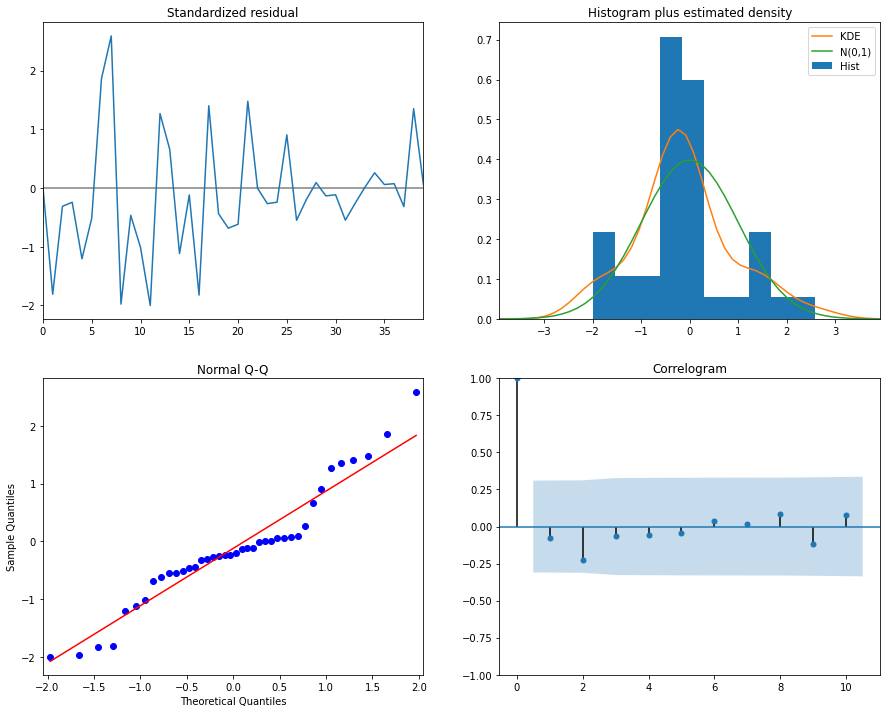

In [164]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

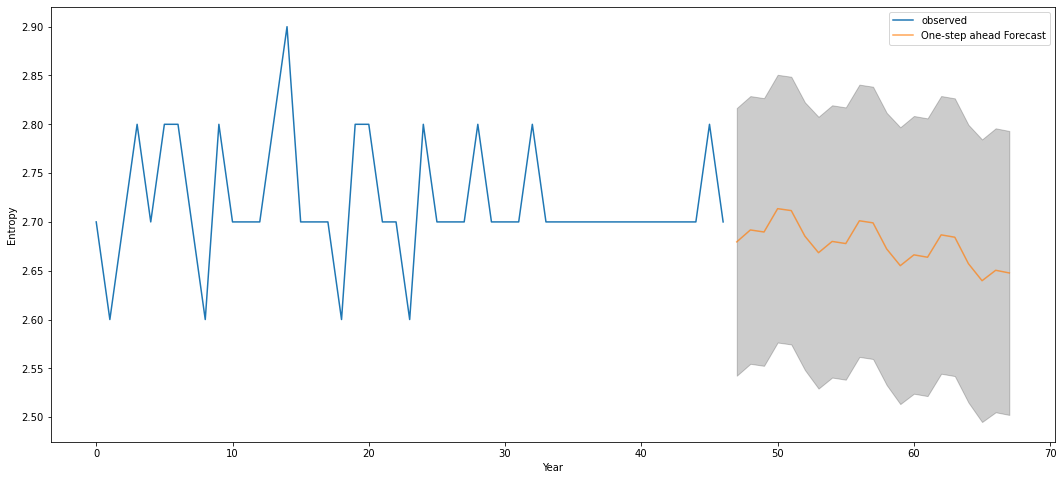

In [189]:
pred = results.get_prediction(start=len(avg_ent_year), end = len(avg_ent_year)+20, dynamic=False)
pred_ci = pred.conf_int()

ax = avg_ent_year['mode'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('Entropy')
plt.legend()

plt.show()

In [195]:
##CHECK FOR FEMALES
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(fem_sum['mode'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}6 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 6)6 - AIC:-38.757161694777366
ARIMA(0, 1, 0)x(0, 1, 1, 6)6 - AIC:-45.73903682448513
ARIMA(0, 1, 0)x(0, 1, 2, 6)6 - AIC:nan
ARIMA(0, 1, 0)x(1, 1, 0, 6)6 - AIC:-38.20116033766426
ARIMA(0, 1, 0)x(1, 1, 1, 6)6 - AIC:-40.81303763279564
ARIMA(0, 1, 0)x(1, 1, 2, 6)6 - AIC:nan
ARIMA(0, 1, 0)x(2, 1, 0, 6)6 - AIC:-37.03583403102883
ARIMA(0, 1, 0)x(2, 1, 1, 6)6 - AIC:-38.69956708748148
ARIMA(0, 1, 0)x(2, 1, 2, 6)6 - AIC:nan
ARIMA(0, 1, 1)x(0, 1, 0, 6)6 - AIC:-65.1292530086362
ARIMA(0, 1, 1)x(0, 1, 1, 6)6 - AIC:-63.600843361267536
ARIMA(0, 1, 1)x(0, 1, 2, 6)6 - AIC:1186.1081093967937
ARIMA(0, 1, 1)x(1, 1, 0, 6)6 - AIC:-61.07028736307498
ARIMA(0, 1, 1)x(1, 1, 1, 6)6 - AIC:-63.94094997379217
ARIMA(0, 1, 1)x(1, 1, 2, 6)6 - AIC:-47.358320121058384
ARIMA(0, 1, 1)x(2, 1, 0, 6)6 - AIC:-57.9567679077892
ARIMA(0, 1, 1)x(2, 1, 1, 6)6 - AIC:-58.18404064470354
ARIMA(0, 1, 1)x(2, 1, 2, 6)6 - AIC:-57.123967032721126
ARIMA(0, 1, 2)x(0, 1, 0, 6)6 - AIC:-64.47952162979149
ARIMA(0, 1, 2)x(0

In [197]:
#the model with the lowest AIC:ARIMA(1, 1, 1)x(0, 1, 0, 6)6 - AIC:-68.85650743256323

model_fem=sm.tsa.statespace.SARIMAX(endog=fem_sum['mode'],order=(1,1,1),seasonal_order=(0,1,0,6),trend='c',enforce_invertibility=False)
results_fem=model_fem.fit()
print(results_fem.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               mode   No. Observations:                   45
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 6)   Log Likelihood                  37.668
Date:                            Mon, 24 May 2021   AIC                            -67.337
Time:                                    21:33:14   BIC                            -60.787
Sample:                                         0   HQIC                           -65.006
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.006      0.252      0.801      -0.011       0.014
ar.L1         -0.5101      0.231   

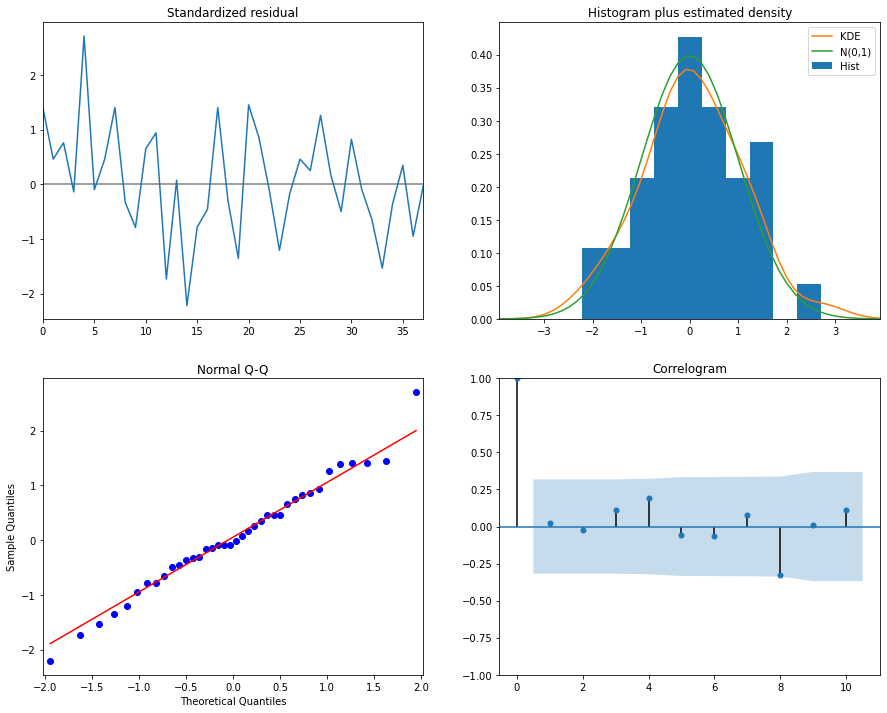

In [198]:
results_fem.plot_diagnostics(figsize=(15, 12))
plt.show()

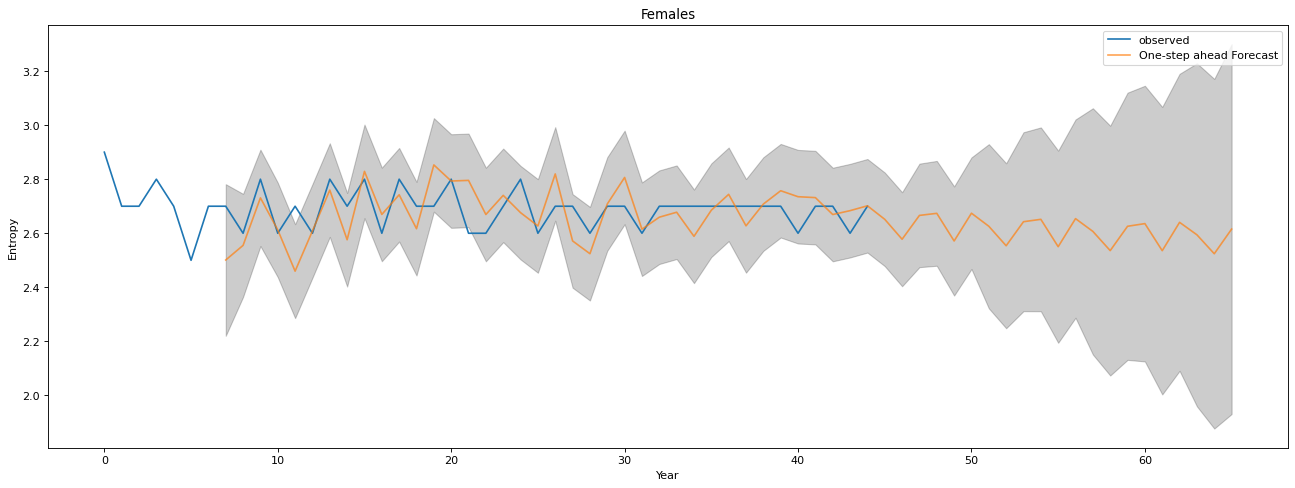

In [280]:
plt.figure( figsize=(20,7), dpi= 80)
pred_fem = results_fem.get_prediction(start=7, end = len(fem_sum)+20, dynamic=False)
pred_ci_fem = pred_fem.conf_int()

ax_fem = fem_sum['mode'].plot(label='observed')
pred_fem.predicted_mean.plot(ax=ax_fem, label='One-step ahead Forecast', alpha=.7)

ax_fem.fill_between(pred_ci_fem.index,
                pred_ci_fem.iloc[:, 0],
                pred_ci_fem.iloc[:, 1], color='k', alpha=.2)

ax_fem.set_xlabel('Year')
ax_fem.set_ylabel('Entropy')
plt.legend()
plt.title('Females')

plt.show()

In [258]:
fem_sum.head()

,year,n_songs,average_ent,mode,change_mode,change_average
0,1970,13,2.808608,2.9,NaN,NaN
1,1971,21,2.800999,2.7,-0.2,-0.007608
2,1972,38,2.740950,2.7,0.0,-0.060049
3,1973,34,2.810167,2.8,0.1,0.069217
4,1974,1,2.729019,2.7,-0.1,-0.081148


In [267]:
fem_sum['index'] = range(1, len(fem_sum) + 1)

In [265]:
fem_sum['year'] = fem_sum.year.astype(str)

In [272]:
results_fem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               mode   No. Observations:                   45
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 6)   Log Likelihood                  37.668
Date:                            Mon, 24 May 2021   AIC                            -67.337
Time:                                    22:36:36   BIC                            -60.787
Sample:                                         0   HQIC                           -65.006
                                             - 45                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.006      0.252      0.801      -0.011       0.014
ar.L1         -0.5101      0.231     -2.211      0.027      -0.962      -0.058
ma.L1         -0.5862      0.203     -2.883      0.004      -0.985      -0.188
sigma2         0.0078      0.002      3.895      0.000       0.004       0.012
===================================================================================
Ljung-Box (Q):                       34.93   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.57   Prob(JB):                         0.95
Heteroskedasticity (H):               0.39   Skew:                             0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [273]:
results_fem.get_prediction(start=6, end = len(fem_sum), dynamic=False)


In [237]:
fem_sum = fem_sum.set_index('year')#df.loc[row_indexer,column_indexer]

In [242]:
fem_sum.head()

,n_songs,average_ent,mode,change_mode,change_average
year,,,,,
1970,13,2.808608,2.9,NaN,NaN
1971,21,2.800999,2.7,-0.2,-0.007608
1972,38,2.740950,2.7,0.0,-0.060049
1973,34,2.810167,2.8,0.1,0.069217
1974,1,2.729019,2.7,-0.1,-0.081148


In [283]:
#Calculate model performance
fem_forecasted = pred_fem.predicted_mean
fem_truth = fem_sum['mode']
mse_fem = ((fem_forecasted - fem_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse_fem, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse_fem), 2)))




The Mean Squared Error is 0.01
The Root Mean Squared Error is 0.09


In [203]:
# check males
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(male_sum['mode'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}6 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 6)6 - AIC:-28.67209080549931
ARIMA(0, 1, 0)x(0, 1, 1, 6)6 - AIC:-64.38078726597519
ARIMA(0, 1, 0)x(0, 1, 2, 6)6 - AIC:-55.52756518222357
ARIMA(0, 1, 0)x(1, 1, 0, 6)6 - AIC:-54.40229650394174
ARIMA(0, 1, 0)x(1, 1, 1, 6)6 - AIC:-53.831700857679905
ARIMA(0, 1, 0)x(1, 1, 2, 6)6 - AIC:33102.839465727004
ARIMA(0, 1, 0)x(2, 1, 0, 6)6 - AIC:-54.66545494129477
ARIMA(0, 1, 0)x(2, 1, 1, 6)6 - AIC:-53.683941526805256
ARIMA(0, 1, 0)x(2, 1, 2, 6)6 - AIC:49680.84629772539
ARIMA(0, 1, 1)x(0, 1, 0, 6)6 - AIC:-64.42502243796486
ARIMA(0, 1, 1)x(0, 1, 1, 6)6 - AIC:-79.17848916277052
ARIMA(0, 1, 1)x(0, 1, 2, 6)6 - AIC:-58.203500091299816
ARIMA(0, 1, 1)x(1, 1, 0, 6)6 - AIC:-67.95788139749001
ARIMA(0, 1, 1)x(1, 1, 1, 6)6 - AIC:-71.84621754135286
ARIMA(0, 1, 1)x(1, 1, 2, 6)6 - AIC:-61.120201709626116
ARIMA(0, 1, 1)x(2, 1, 0, 6)6 - AIC:-64.81567998287964
ARIMA(0, 1, 1)x(2, 1, 1, 6)6 - AIC:-63.310091279197906
ARIMA(0, 1, 1)x(2, 1, 2, 6)6 - AIC:-62.76306981805254
ARIMA(0, 1, 2)x(0, 1, 0,

In [204]:
#the model with the lowest AIC:ARIMA(1, 1, 1)x(0, 1, 1, 6)6 - AIC:-77.21062764485191

model_male=sm.tsa.statespace.SARIMAX(endog=male_sum['mode'],order=(1,1,1),seasonal_order=(0,1,1,6),trend='c',enforce_invertibility=False)
results_male=model_male.fit()
print(results_male.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              mode   No. Observations:                   47
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 6)   Log Likelihood                  39.178
Date:                           Mon, 24 May 2021   AIC                            -68.356
Time:                                   21:41:30   BIC                            -59.912
Sample:                                        0   HQIC                           -65.303
                                            - 47                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.002     -0.242      0.808      -0.004       0.003
ar.L1         -0.0568      0.258     -0.220

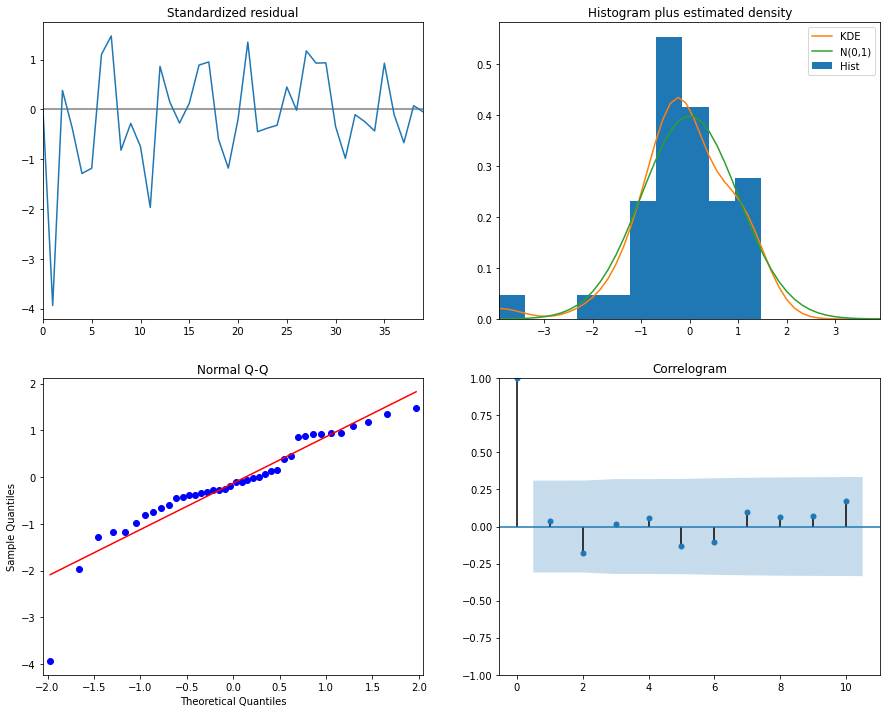

In [205]:
results_male.plot_diagnostics(figsize=(15, 12))
plt.show()

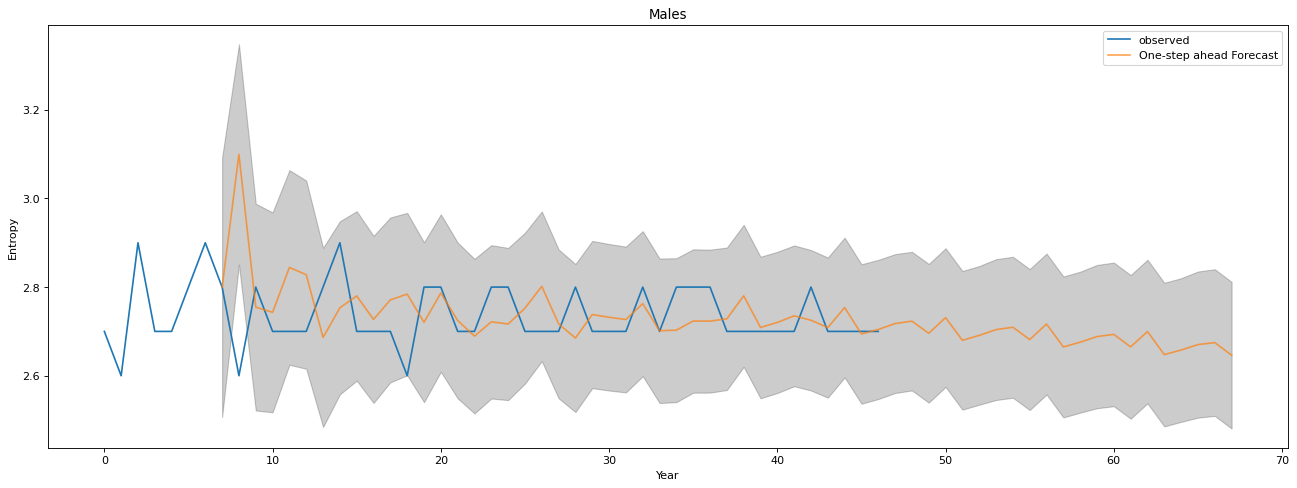

In [282]:
plt.figure( figsize=(20,7), dpi= 80)

pred_male = results_male.get_prediction(start=7, end = len(male_sum)+20, dynamic=False)
pred_ci_male = pred_male.conf_int()

ax_male = male_sum['mode'].plot(label='observed')
pred_male.predicted_mean.plot(ax=ax_male, label='One-step ahead Forecast', alpha=.7)

ax_male.fill_between(pred_ci_male.index,
                pred_ci_male.iloc[:, 0],
                pred_ci_male.iloc[:, 1], color='k', alpha=.2)

ax_male.set_xlabel('Year')
ax_male.set_ylabel('Entropy')
plt.title('Males')
plt.legend()

plt.show()

In [284]:
#Calculate model performance
male_forecasted = pred_male.predicted_mean
male_truth = male_sum['mode']
mse_male = ((male_forecasted - male_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse_male, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse_male), 2)))

The Mean Squared Error is 0.01
The Root Mean Squared Error is 0.11


In [291]:
male_sum['mode'].describe()

count    47.000000
mean      2.736170
std       0.070481
min       2.600000
25%       2.700000
50%       2.700000
75%       2.800000
max       2.900000
Name: mode, dtype: float64